# Chatting bot Topic Clustering

<b style = "color:red">Important!</b>


**Check the setup.ipynb to find the modules needed**

Dataset url https://github.com/google-research-datasets/Taskmaster/raw/master/TM-1-2019

In [1]:
__author__ = ["Haolin Pan", "Riade Benbaki"]
__version__ = "École Polytechnique, 2020/3/31"
__data__ = "https://github.com/riadeb/Topic_Clustering"

# Set up

In [5]:
# set up
from collections import defaultdict
import numpy as np
import pandas as pd
import requests
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.enable_eager_execution() #Should be commented for training with tf1 only
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import metrics

from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

### To use GPU with TF 
Execute following cell and check whether TF detects your GPU or not

In [2]:
print(tf.__version__)
tf.config.experimental.list_physical_devices()


1.15.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

### The local .py

In [8]:
from src.topic_clustering_model import Topic_clustering

# Initialization

In [9]:
TCM = Topic_clustering() #If you have saved weights in directory, include it's relative path

module use loaded
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


module elmo loaded
module nnlm loaded
Gnews Swivel loaded
Loaded weights for model elmo
Loaded weights for model use


# Data

### Raw Data

In [5]:
TCM.data[:2]

[{'conversation_id': 'dlg-00055f4e-4a46-48bf-8d99-4e477663eb23',
  'instruction_id': 'restaurant-table-2',
  'utterances': [{'index': 0,
    'speaker': 'USER',
    'text': "Hi, I'm looking to book a table for Korean fod."},
   {'index': 1,
    'speaker': 'ASSISTANT',
    'text': 'Ok, what area are you thinking about?'},
   {'index': 2,
    'speaker': 'USER',
    'text': 'Somewhere in Southern NYC, maybe the East Village?',
    'segments': [{'start_index': 13,
      'end_index': 49,
      'text': 'Southern NYC, maybe the East Village',
      'annotations': [{'name': 'restaurant_reservation.location.restaurant.accept'}]},
     {'start_index': 13,
      'end_index': 25,
      'text': 'Southern NYC',
      'annotations': [{'name': 'restaurant_reservation.location.restaurant.accept'}]}]},
   {'index': 3,
    'speaker': 'ASSISTANT',
    'text': "Ok, great.  There's Thursday Kitchen, it has great reviews.",
    'segments': [{'start_index': 20,
      'end_index': 35,
      'text': 'Thursday Ki

We can see there are more information in the raw data, we use `data_prerocessing` to select the phrases as `X` and topics as `y`

In [6]:
TCM.data_precessing()

The numbers of samples we take from the original data: 
auto : 	 1161
coffee : 	 1376
movie : 	 1305
pizza : 	 1400
restaurant : 	 1300
uber : 	 1098
non-opening : 	 1400
Total:	  9040


In [7]:
TCM.X[:10]

array(["Hi, I'm looking to book a table for Korean fod.",
       "They don't have any availability for 7 pm.",
       'Hi I would like to see if the Movie What Men Want is playing here.',
       'Okay. How to train your dragon is playing at 8pm.',
       'I want to watch avengers endgame', "8 o'clock",
       'I want to order a pizza from Bertuccis in Chelmsford, MA',
       'a large please', "Hi I'd like to order two large pizzas.",
       'thank you very much. Is there anything else I can get for you?'],
      dtype='<U283')

In [8]:
TCM.y[:10]

array([[0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]])

# Modeling

We choosed four different kinds of modeling structure to build the topic clustering system and compare their performance.
<ul>
    <li> nnlm-en-dim128 + Dense  <b>( Baseline )</b> </li>
    <li> gnews-swivel-20dim + Dense</li>
    <li> universal-sentence-encoder(dim512) + Dense</li>
    <li> elmo + Dense</li>
</ul>


First we embedded the data with the four models above. Then we divided the embedded data into `dev` set (90%) and `test` set (10%)

The `dev` sets contain the training set and validation set with which we tune the hyperparameters

The `test` sets are only used in the final evaluation 

In [9]:
TCM.word_embedding() #Loads embeding models and calculates embeding of data, then saves them is csv files
#If csv files exist, loads embedings directly 



training data loaded


In [10]:
for em in TCM.data_zoo.keys():
    print(128 * "=")
    print(em)
    print("number of sample in dev set: \t", TCM.data_zoo[em]['dev'][0].shape[0])
    print("number of sample in test set: \t", TCM.data_zoo[em]['test'][0].shape[0])
print(128 * "=")

elmo
number of sample in dev set: 	 8136
number of sample in test set: 	 904
use
number of sample in dev set: 	 8136
number of sample in test set: 	 904
nnlm
number of sample in dev set: 	 8136
number of sample in test set: 	 904
gnew
number of sample in dev set: 	 8136
number of sample in test set: 	 904


## Hyper parameter tuning

In [12]:
tf.compat.v1.disable_eager_execution()

There are not many hyper parameters in our models to be tuned. 

We mainly focused on the hyperparameters below: 

loss : ` ['categorical_crossentropy', 'cosine_similarity', 'binary_crossentropy','kullback_leibler_divergence','hinge']`

optimizer : ` ['adam', 'sgd'] `

we evaluate the performance of the models by the `f1_score_macro`

In [13]:
TCM.hyper_parameter_tuning()

Tuning  elmo
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 31us/sample - loss: 1.1260 - mean_absolute_error: 0.1753 - categorical_accuracy: 0.7371
Epoch 2/3
6508/6508 [==============================] - 0s 16us/sample - loss: 0.5721 - mean_absolute_error: 0.1015 - categorical_accuracy: 0.8861
Epoch 3/3
6508/6508 [==============================] - 0s 16us/sample - loss: 0.4343 - mean_absolute_error: 0.0773 - categorical_accuracy: 0.9080
f1_macro:  0.8995758732100209
f1_micro:  0.8980343980343981
f1_weighted:  0.8987881699663014
categorical_crossentropy ,  adam :  (0.8995758732100209, 0.8995758732100209)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 27us/sample - loss: 1.7456 - mean_absolute_error: 0.2331 - categorical_accuracy: 0.4161
Epoch 2/3
6508/6508 [==============================] - 0s 15us/sample - loss: 1.3998 - mean_absolute_error: 0.2099 - categorical_accuracy: 0.7196
Epoch 3/3
6508/6508 [=====================

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 32us/sample - loss: 0.1314 - mean_absolute_error: 0.2643 - categorical_accuracy: 0.0750
Epoch 2/3
6508/6508 [==============================] - 0s 17us/sample - loss: 0.0380 - mean_absolute_error: 0.2778 - categorical_accuracy: 0.0175
Epoch 3/3
6508/6508 [==============================] - 0s 17us/sample - loss: 0.0265 - mean_absolute_error: 0.2800 - categorical_accuracy: 0.0121
f1_macro:  0.005498160889108532
f1_micro:  0.011056511056511058
f1_weighted:  0.006232913886735493
cosine_similarity ,  adam :  (0.005498160889108532, 0.005498160889108532)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2365 - mean_absolute_error: 0.2491 - categorical_accuracy: 0.1242
Epoch 2/3
6508/6508 [==============================] - 0s 17us/sample - loss: 0.1421 - mean_absolute_error: 0.2508 - categorical_accuracy: 0.1214
Epoch 3/3
6508/6508 [==============================]

Epoch 1/3
6508/6508 [==============================] - 0s 34us/sample - loss: 0.3787 - mean_absolute_error: 0.2448 - categorical_accuracy: 0.2016
Epoch 2/3
6508/6508 [==============================] - 0s 17us/sample - loss: 0.3747 - mean_absolute_error: 0.2452 - categorical_accuracy: 0.1377
Epoch 3/3
6508/6508 [==============================] - 0s 17us/sample - loss: 0.3706 - mean_absolute_error: 0.2456 - categorical_accuracy: 0.0876
f1_macro:  0.06820035962850882
f1_micro:  0.07186732186732187
f1_weighted:  0.0675691587761014
cosine_similarity ,  sgd :  (0.06820035962850882, 0.06820035962850882)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 37us/sample - loss: 0.3642 - mean_absolute_error: 0.2308 - categorical_accuracy: 0.7256
Epoch 2/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.2802 - mean_absolute_error: 0.1953 - categorical_accuracy: 0.8537
Epoch 3/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.2

Epoch 1/3
6508/6508 [==============================] - 0s 41us/sample - loss: 0.3943 - mean_absolute_error: 0.2404 - categorical_accuracy: 0.3781
Epoch 2/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.3672 - mean_absolute_error: 0.2321 - categorical_accuracy: 0.6148
Epoch 3/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.3428 - mean_absolute_error: 0.2231 - categorical_accuracy: 0.7057
f1_macro:  0.7046914123739935
f1_micro:  0.7125307125307125
f1_weighted:  0.7037415929329217
binary_crossentropy ,  adam :  (0.7046914123739935, 0.7046914123739935)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 43us/sample - loss: 0.4084 - mean_absolute_error: 0.2441 - categorical_accuracy: 0.1852
Epoch 2/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.4080 - mean_absolute_error: 0.2440 - categorical_accuracy: 0.1901
Epoch 3/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.40

Epoch 1/3
6508/6508 [==============================] - 0s 47us/sample - loss: 0.5025 - mean_absolute_error: 0.2418 - categorical_accuracy: 0.1905
Epoch 2/3
6508/6508 [==============================] - 0s 18us/sample - loss: 0.4596 - mean_absolute_error: 0.2414 - categorical_accuracy: 0.1947
Epoch 3/3
6508/6508 [==============================] - 0s 19us/sample - loss: 0.4365 - mean_absolute_error: 0.2407 - categorical_accuracy: 0.1939
f1_macro:  0.14732761556081758
f1_micro:  0.18857493857493857
f1_weighted:  0.13604907586868664
binary_crossentropy ,  sgd :  (0.14732761556081758, 0.14732761556081758)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 46us/sample - loss: 2.1719 - mean_absolute_error: 0.2379 - categorical_accuracy: 0.2044
Epoch 2/3
6508/6508 [==============================] - 0s 18us/sample - loss: 1.8397 - mean_absolute_error: 0.2307 - categorical_accuracy: 0.2929
Epoch 3/3
6508/6508 [==============================] - 0s 18us/sample - loss: 

In [14]:
for em in TCM.best_hyper_parameter.keys():
    print(128* "=")
    print("The optimal hyperparameters for model ", em)
    print("loss : ", TCM.best_hyper_parameter[em][0], "; optimizer : ", TCM.best_hyper_parameter[em][1],
          "; f1_macro: ", TCM.best_hyper_parameter[em][2])
print(128 * "=")

The optimal hyperparameters for model  elmo
loss :  kullback_leibler_divergence ; optimizer :  adam ; f1_macro:  0.9038260020244548
The optimal hyperparameters for model  use
loss :  kullback_leibler_divergence ; optimizer :  adam ; f1_macro:  0.8754386653190771
The optimal hyperparameters for model  nnlm
loss :  kullback_leibler_divergence ; optimizer :  adam ; f1_macro:  0.7298438414309245
The optimal hyperparameters for model  gnew
loss :  kullback_leibler_divergence ; optimizer :  adam ; f1_macro:  0.38830327196962117


## Early stop

Searching  elmo
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 0s 40us/sample - loss: 1.3995 - mean_absolute_error: 0.2047 - categorical_accuracy: 0.6395
Epoch 2/3
6508/6508 [==============================] - 0s 11us/sample - loss: 0.7768 - mean_absolute_error: 0.1354 - categorical_accuracy: 0.8602
Epoch 3/3
6508/6508 [==============================] - 0s 11us/sample - loss: 0.5741 - mean_absolute_error: 0.1028 - categorical_accuracy: 0.8895
f1_macro:  0.8883866728777494
f1_micro:  0.8869778869778869
f1_weighted:  0.8875486724501369
Train on 6508 samples
Epoch 1/4
6508/6508 [==============================] - 0s 43us/sample - loss: 1.3404 - mean_absolute_error: 0.2000 - categorical_accuracy: 0.6875
Epoch 2/4
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7498 - mean_absolute_error: 0.1308 - categorical_accuracy: 0.8714
Epoch 3/4
6508/6508 [==============================] - 0s 11us/sample - loss: 0.5592 - mean_absolute_error: 0.0999 - 

6508/6508 [==============================] - 0s 12us/sample - loss: 0.2636 - mean_absolute_error: 0.0458 - categorical_accuracy: 0.9316
Epoch 13/14
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2539 - mean_absolute_error: 0.0441 - categorical_accuracy: 0.9342
Epoch 14/14
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2442 - mean_absolute_error: 0.0423 - categorical_accuracy: 0.9359
f1_macro:  0.9188217079300368
f1_micro:  0.918918918918919
f1_weighted:  0.9190023434912258
Train on 6508 samples
Epoch 1/17
6508/6508 [==============================] - 0s 44us/sample - loss: 1.3158 - mean_absolute_error: 0.1981 - categorical_accuracy: 0.6879
Epoch 2/17
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7427 - mean_absolute_error: 0.1301 - categorical_accuracy: 0.8666
Epoch 3/17
6508/6508 [==============================] - 0s 12us/sample - loss: 0.5556 - mean_absolute_error: 0.0995 - categorical_accuracy: 0.8917
Epoch 4/17
65

6508/6508 [==============================] - 0s 12us/sample - loss: 0.2551 - mean_absolute_error: 0.0444 - categorical_accuracy: 0.9353
Epoch 14/26
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2468 - mean_absolute_error: 0.0427 - categorical_accuracy: 0.9370
Epoch 15/26
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2389 - mean_absolute_error: 0.0414 - categorical_accuracy: 0.9372
Epoch 16/26
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2316 - mean_absolute_error: 0.0400 - categorical_accuracy: 0.9387
Epoch 17/26
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2249 - mean_absolute_error: 0.0389 - categorical_accuracy: 0.9419
Epoch 18/26
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2190 - mean_absolute_error: 0.0379 - categorical_accuracy: 0.9424
Epoch 19/26
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2138 - mean_absolute_error: 0.0370 - categ

Epoch 9/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3008 - mean_absolute_error: 0.0527 - categorical_accuracy: 0.9264
Epoch 10/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2859 - mean_absolute_error: 0.0502 - categorical_accuracy: 0.9296
Epoch 11/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2738 - mean_absolute_error: 0.0478 - categorical_accuracy: 0.9327
Epoch 12/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2625 - mean_absolute_error: 0.0456 - categorical_accuracy: 0.9350
Epoch 13/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2529 - mean_absolute_error: 0.0439 - categorical_accuracy: 0.9361
Epoch 14/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2441 - mean_absolute_error: 0.0424 - categorical_accuracy: 0.9362
Epoch 15/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2364 - mean_absolute_error: 0.0

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1896 - mean_absolute_error: 0.0329 - categorical_accuracy: 0.9481
Epoch 25/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1861 - mean_absolute_error: 0.0323 - categorical_accuracy: 0.9496
Epoch 26/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1824 - mean_absolute_error: 0.0317 - categorical_accuracy: 0.9519
Epoch 27/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1791 - mean_absolute_error: 0.0312 - categorical_accuracy: 0.9524
Epoch 28/47
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1760 - mean_absolute_error: 0.0308 - categorical_accuracy: 0.9533
Epoch 29/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1726 - mean_absolute_error: 0.0302 - categorical_accuracy: 0.9527
Epoch 30/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1701 - mean_absolute_error: 0.0297 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.1675 - mean_absolute_error: 0.0294 - categorical_accuracy: 0.9547
Epoch 32/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1653 - mean_absolute_error: 0.0290 - categorical_accuracy: 0.9568
Epoch 33/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1629 - mean_absolute_error: 0.0286 - categorical_accuracy: 0.9559
Epoch 34/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1603 - mean_absolute_error: 0.0281 - categorical_accuracy: 0.9561
Epoch 35/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1570 - mean_absolute_error: 0.0278 - categorical_accuracy: 0.9590
Epoch 36/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1546 - mean_absolute_error: 0.0273 - categorical_accuracy: 0.9593
Epoch 37/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1523 - mean_absolute_error: 0.0271 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.1760 - mean_absolute_error: 0.0309 - categorical_accuracy: 0.9530
Epoch 29/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1732 - mean_absolute_error: 0.0304 - categorical_accuracy: 0.9521
Epoch 30/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1702 - mean_absolute_error: 0.0299 - categorical_accuracy: 0.9541
Epoch 31/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1672 - mean_absolute_error: 0.0294 - categorical_accuracy: 0.9553
Epoch 32/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1648 - mean_absolute_error: 0.0290 - categorical_accuracy: 0.9559
Epoch 33/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1620 - mean_absolute_error: 0.0286 - categorical_accuracy: 0.9565
Epoch 34/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1596 - mean_absolute_error: 0.0282 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.2538 - mean_absolute_error: 0.0440 - categorical_accuracy: 0.9342
Epoch 14/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2450 - mean_absolute_error: 0.0425 - categorical_accuracy: 0.9372
Epoch 15/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2375 - mean_absolute_error: 0.0411 - categorical_accuracy: 0.9395
Epoch 16/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2306 - mean_absolute_error: 0.0399 - categorical_accuracy: 0.9402
Epoch 17/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2236 - mean_absolute_error: 0.0387 - categorical_accuracy: 0.9415
Epoch 18/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2179 - mean_absolute_error: 0.0377 - categorical_accuracy: 0.9422
Epoch 19/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2123 - mean_absolute_error: 0.0367 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.1052 - mean_absolute_error: 0.0198 - categorical_accuracy: 0.9740
Epoch 69/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1043 - mean_absolute_error: 0.0196 - categorical_accuracy: 0.9742
Epoch 70/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1030 - mean_absolute_error: 0.0194 - categorical_accuracy: 0.9754
Epoch 71/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1024 - mean_absolute_error: 0.0193 - categorical_accuracy: 0.9766
Epoch 72/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1013 - mean_absolute_error: 0.0191 - categorical_accuracy: 0.9760
Epoch 73/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.0999 - mean_absolute_error: 0.0190 - categorical_accuracy: 0.9763
Epoch 74/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.0994 - mean_absolute_error: 0.0188 - categ

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1479 - mean_absolute_error: 0.0263 - categorical_accuracy: 0.9619
Epoch 40/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1454 - mean_absolute_error: 0.0259 - categorical_accuracy: 0.9614
Epoch 41/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1434 - mean_absolute_error: 0.0257 - categorical_accuracy: 0.9614
Epoch 42/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1421 - mean_absolute_error: 0.0254 - categorical_accuracy: 0.9620
Epoch 43/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1399 - mean_absolute_error: 0.0251 - categorical_accuracy: 0.9642
Epoch 44/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1382 - mean_absolute_error: 0.0248 - categorical_accuracy: 0.9639
Epoch 45/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1364 - mean_absolute_error: 0.0245 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.0824 - mean_absolute_error: 0.0162 - categorical_accuracy: 0.9816
Epoch 95/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0816 - mean_absolute_error: 0.0160 - categorical_accuracy: 0.9819
Epoch 96/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0810 - mean_absolute_error: 0.0160 - categorical_accuracy: 0.9820
Epoch 97/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0808 - mean_absolute_error: 0.0159 - categorical_accuracy: 0.9817
Epoch 98/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0800 - mean_absolute_error: 0.0157 - categorical_accuracy: 0.9834
Epoch 99/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0792 - mean_absolute_error: 0.0156 - categorical_accuracy: 0.9831
Epoch 100/100
6508/6508 [==============================] - 0s 12us/sample - loss: 0.0782 - mean_absolute_error: 0.0155 

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1316 - mean_absolute_error: 0.0238 - categorical_accuracy: 0.9654
Epoch 49/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1300 - mean_absolute_error: 0.0235 - categorical_accuracy: 0.9674
Epoch 50/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1286 - mean_absolute_error: 0.0233 - categorical_accuracy: 0.9674
Epoch 51/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1272 - mean_absolute_error: 0.0231 - categorical_accuracy: 0.9680
Epoch 52/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1252 - mean_absolute_error: 0.0228 - categorical_accuracy: 0.9696
Epoch 53/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1237 - mean_absolute_error: 0.0225 - categorical_accuracy: 0.9696
Epoch 54/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1222 - mean_absolute_error: 0.0223 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.0770 - mean_absolute_error: 0.0153 - categorical_accuracy: 0.9842
Epoch 104/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0761 - mean_absolute_error: 0.0151 - categorical_accuracy: 0.9833
Epoch 105/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0757 - mean_absolute_error: 0.0150 - categorical_accuracy: 0.9837
Epoch 106/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0750 - mean_absolute_error: 0.0149 - categorical_accuracy: 0.9845
Epoch 107/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0746 - mean_absolute_error: 0.0148 - categorical_accuracy: 0.9840
Epoch 108/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0738 - mean_absolute_error: 0.0147 - categorical_accuracy: 0.9856
Epoch 109/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0736 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1555 - mean_absolute_error: 0.0275 - categorical_accuracy: 0.9581
Epoch 37/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1526 - mean_absolute_error: 0.0271 - categorical_accuracy: 0.9602
Epoch 38/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1505 - mean_absolute_error: 0.0267 - categorical_accuracy: 0.9599
Epoch 39/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1498 - mean_absolute_error: 0.0266 - categorical_accuracy: 0.9613
Epoch 40/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1469 - mean_absolute_error: 0.0262 - categorical_accuracy: 0.9617
Epoch 41/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1447 - mean_absolute_error: 0.0258 - categorical_accuracy: 0.9627
Epoch 42/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1433 - mean_absolute_error: 0.0255 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.0855 - mean_absolute_error: 0.0166 - categorical_accuracy: 0.9817
Epoch 92/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0842 - mean_absolute_error: 0.0164 - categorical_accuracy: 0.9823
Epoch 93/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0832 - mean_absolute_error: 0.0162 - categorical_accuracy: 0.9817
Epoch 94/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0830 - mean_absolute_error: 0.0163 - categorical_accuracy: 0.9817
Epoch 95/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0826 - mean_absolute_error: 0.0162 - categorical_accuracy: 0.9823
Epoch 96/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0816 - mean_absolute_error: 0.0159 - categorical_accuracy: 0.9822
Epoch 97/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0813 - mean_absolute_error: 0.0160 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.0571 - mean_absolute_error: 0.0118 - categorical_accuracy: 0.9885
Epoch 146/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0570 - mean_absolute_error: 0.0117 - categorical_accuracy: 0.9888
f1_macro:  0.9153945194195144
f1_micro:  0.9158476658476659
f1_weighted:  0.9159768678884003
Train on 6508 samples
Epoch 1/176
6508/6508 [==============================] - 0s 50us/sample - loss: 1.3980 - mean_absolute_error: 0.2051 - categorical_accuracy: 0.6529
Epoch 2/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.7689 - mean_absolute_error: 0.1341 - categorical_accuracy: 0.8637
Epoch 3/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5700 - mean_absolute_error: 0.1020 - categorical_accuracy: 0.8907
Epoch 4/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4722 - mean_absolute_error: 0.0849 - categorical_accuracy: 0.9037
Epoch 5

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1241 - mean_absolute_error: 0.0226 - categorical_accuracy: 0.9693
Epoch 54/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1227 - mean_absolute_error: 0.0224 - categorical_accuracy: 0.9705
Epoch 55/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1220 - mean_absolute_error: 0.0223 - categorical_accuracy: 0.9693
Epoch 56/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1203 - mean_absolute_error: 0.0221 - categorical_accuracy: 0.9705
Epoch 57/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1195 - mean_absolute_error: 0.0220 - categorical_accuracy: 0.9710
Epoch 58/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1173 - mean_absolute_error: 0.0216 - categorical_accuracy: 0.9703
Epoch 59/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1165 - mean_absolute_error: 0.0215 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.0744 - mean_absolute_error: 0.0148 - categorical_accuracy: 0.9843
Epoch 109/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0740 - mean_absolute_error: 0.0148 - categorical_accuracy: 0.9851
Epoch 110/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0731 - mean_absolute_error: 0.0146 - categorical_accuracy: 0.9849
Epoch 111/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0726 - mean_absolute_error: 0.0144 - categorical_accuracy: 0.9842
Epoch 112/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0719 - mean_absolute_error: 0.0144 - categorical_accuracy: 0.9848
Epoch 113/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0714 - mean_absolute_error: 0.0143 - categorical_accuracy: 0.9862
Epoch 114/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0704 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 13us/sample - loss: 0.0512 - mean_absolute_error: 0.0108 - categorical_accuracy: 0.9902
Epoch 163/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0508 - mean_absolute_error: 0.0107 - categorical_accuracy: 0.9905
Epoch 164/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0501 - mean_absolute_error: 0.0106 - categorical_accuracy: 0.9903
Epoch 165/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0504 - mean_absolute_error: 0.0105 - categorical_accuracy: 0.9900
Epoch 166/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0506 - mean_absolute_error: 0.0107 - categorical_accuracy: 0.9902
Epoch 167/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0502 - mean_absolute_error: 0.0105 - categorical_accuracy: 0.9902
Epoch 168/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.0499 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 12us/sample - loss: 0.6971 - mean_absolute_error: 0.1261 - categorical_accuracy: 0.8904
Epoch 9/11
6508/6508 [==============================] - 0s 12us/sample - loss: 0.6407 - mean_absolute_error: 0.1167 - categorical_accuracy: 0.8943
Epoch 10/11
6508/6508 [==============================] - 0s 11us/sample - loss: 0.5944 - mean_absolute_error: 0.1086 - categorical_accuracy: 0.8980
Epoch 11/11
6508/6508 [==============================] - 0s 11us/sample - loss: 0.5559 - mean_absolute_error: 0.1017 - categorical_accuracy: 0.8990
f1_macro:  0.9043837186648676
f1_micro:  0.9041769041769042
f1_weighted:  0.9026165831644355
Train on 6508 samples
Epoch 1/14
6508/6508 [==============================] - 0s 52us/sample - loss: 1.8036 - mean_absolute_error: 0.2382 - categorical_accuracy: 0.6380
Epoch 2/14
6508/6508 [==============================] - 0s 12us/sample - loss: 1.5254 - mean_absolute_error: 0.2214 - categorical_accuracy: 0.8385
Epoch 3/14
6

6508/6508 [==============================] - 0s 12us/sample - loss: 0.3872 - mean_absolute_error: 0.0700 - categorical_accuracy: 0.9140
Epoch 20/21
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3751 - mean_absolute_error: 0.0677 - categorical_accuracy: 0.9147
Epoch 21/21
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3642 - mean_absolute_error: 0.0655 - categorical_accuracy: 0.9158
f1_macro:  0.9176766495868263
f1_micro:  0.9170761670761671
f1_weighted:  0.9164924527437318
Train on 6508 samples
Epoch 1/26
6508/6508 [==============================] - 0s 53us/sample - loss: 1.8057 - mean_absolute_error: 0.2382 - categorical_accuracy: 0.6455
Epoch 2/26
6508/6508 [==============================] - 0s 12us/sample - loss: 1.5295 - mean_absolute_error: 0.2217 - categorical_accuracy: 0.8399
Epoch 3/26
6508/6508 [==============================] - 0s 12us/sample - loss: 1.3016 - mean_absolute_error: 0.2032 - categorical_accuracy: 0.8573
Epoch 4/26
6

6508/6508 [==============================] - 0s 12us/sample - loss: 0.3210 - mean_absolute_error: 0.0569 - categorical_accuracy: 0.9216
Epoch 27/32
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3143 - mean_absolute_error: 0.0556 - categorical_accuracy: 0.9230
Epoch 28/32
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3080 - mean_absolute_error: 0.0543 - categorical_accuracy: 0.9233
Epoch 29/32
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3021 - mean_absolute_error: 0.0532 - categorical_accuracy: 0.9242
Epoch 30/32
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2966 - mean_absolute_error: 0.0521 - categorical_accuracy: 0.9258
Epoch 31/32
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2915 - mean_absolute_error: 0.0510 - categorical_accuracy: 0.9262
Epoch 32/32
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2866 - mean_absolute_error: 0.0501 - categ

Epoch 9/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.6404 - mean_absolute_error: 0.1166 - categorical_accuracy: 0.8921
Epoch 10/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.5941 - mean_absolute_error: 0.1086 - categorical_accuracy: 0.8969
Epoch 11/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.5555 - mean_absolute_error: 0.1017 - categorical_accuracy: 0.8987
Epoch 12/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.5229 - mean_absolute_error: 0.0958 - categorical_accuracy: 0.9001
Epoch 13/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4950 - mean_absolute_error: 0.0906 - categorical_accuracy: 0.9029
Epoch 14/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4710 - mean_absolute_error: 0.0861 - categorical_accuracy: 0.9043
Epoch 15/47
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4499 - mean_absolute_error: 0.0

6508/6508 [==============================] - 0s 13us/sample - loss: 0.4320 - mean_absolute_error: 0.0788 - categorical_accuracy: 0.9093
Epoch 17/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4154 - mean_absolute_error: 0.0756 - categorical_accuracy: 0.9103
Epoch 18/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4005 - mean_absolute_error: 0.0727 - categorical_accuracy: 0.9118
Epoch 19/57
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3872 - mean_absolute_error: 0.0701 - categorical_accuracy: 0.9140
Epoch 20/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3751 - mean_absolute_error: 0.0677 - categorical_accuracy: 0.9149
Epoch 21/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3642 - mean_absolute_error: 0.0655 - categorical_accuracy: 0.9163
Epoch 22/57
6508/6508 [==============================] - 0s 12us/sample - loss: 0.3541 - mean_absolute_error: 0.0635 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.4967 - mean_absolute_error: 0.0909 - categorical_accuracy: 0.9030
Epoch 14/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4724 - mean_absolute_error: 0.0864 - categorical_accuracy: 0.9050
Epoch 15/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4512 - mean_absolute_error: 0.0824 - categorical_accuracy: 0.9073
Epoch 16/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4325 - mean_absolute_error: 0.0788 - categorical_accuracy: 0.9090
Epoch 17/69
6508/6508 [==============================] - 0s 12us/sample - loss: 0.4159 - mean_absolute_error: 0.0755 - categorical_accuracy: 0.9103
Epoch 18/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4011 - mean_absolute_error: 0.0727 - categorical_accuracy: 0.9118
Epoch 19/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3877 - mean_absolute_error: 0.0701 - categ

6508/6508 [==============================] - 0s 13us/sample - loss: 0.2023 - mean_absolute_error: 0.0331 - categorical_accuracy: 0.9419
Epoch 69/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2010 - mean_absolute_error: 0.0329 - categorical_accuracy: 0.9424
f1_macro:  0.9333154814387024
f1_micro:  0.933046683046683
f1_weighted:  0.932882149545738
Train on 6508 samples
Epoch 1/83
6508/6508 [==============================] - 0s 60us/sample - loss: 1.7921 - mean_absolute_error: 0.2376 - categorical_accuracy: 0.6656
Epoch 2/83
6508/6508 [==============================] - 0s 13us/sample - loss: 1.5164 - mean_absolute_error: 0.2208 - categorical_accuracy: 0.8390
Epoch 3/83
6508/6508 [==============================] - 0s 13us/sample - loss: 1.2895 - mean_absolute_error: 0.2021 - categorical_accuracy: 0.8622
Epoch 4/83
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1078 - mean_absolute_error: 0.1834 - categorical_accuracy: 0.8699
Epoch 5/83
6508

6508/6508 [==============================] - 0s 13us/sample - loss: 0.2247 - mean_absolute_error: 0.0375 - categorical_accuracy: 0.9367
Epoch 54/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2229 - mean_absolute_error: 0.0371 - categorical_accuracy: 0.9367
Epoch 55/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2211 - mean_absolute_error: 0.0368 - categorical_accuracy: 0.9378
Epoch 56/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2193 - mean_absolute_error: 0.0364 - categorical_accuracy: 0.9379
Epoch 57/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2176 - mean_absolute_error: 0.0361 - categorical_accuracy: 0.9381
Epoch 58/83
6508/6508 [==============================] - 0s 12us/sample - loss: 0.2160 - mean_absolute_error: 0.0358 - categorical_accuracy: 0.9390
Epoch 59/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2145 - mean_absolute_error: 0.0355 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.3368 - mean_absolute_error: 0.0601 - categorical_accuracy: 0.9192
Epoch 25/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3290 - mean_absolute_error: 0.0585 - categorical_accuracy: 0.9204
Epoch 26/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3217 - mean_absolute_error: 0.0570 - categorical_accuracy: 0.9218
Epoch 27/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3149 - mean_absolute_error: 0.0557 - categorical_accuracy: 0.9224
Epoch 28/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3087 - mean_absolute_error: 0.0545 - categorical_accuracy: 0.9239
Epoch 29/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3028 - mean_absolute_error: 0.0533 - categorical_accuracy: 0.9246
Epoch 30/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2972 - mean_absolute_error: 0.0521 -

6508/6508 [==============================] - 0s 12us/sample - loss: 0.1903 - mean_absolute_error: 0.0309 - categorical_accuracy: 0.9464
Epoch 80/100
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1893 - mean_absolute_error: 0.0307 - categorical_accuracy: 0.9461
Epoch 81/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1884 - mean_absolute_error: 0.0305 - categorical_accuracy: 0.9464
Epoch 82/100
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1875 - mean_absolute_error: 0.0303 - categorical_accuracy: 0.9465
Epoch 83/100
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1866 - mean_absolute_error: 0.0302 - categorical_accuracy: 0.9464
Epoch 84/100
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1857 - mean_absolute_error: 0.0300 - categorical_accuracy: 0.9470
Epoch 85/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1848 - mean_absolute_error: 0.0298 -

6508/6508 [==============================] - 0s 12us/sample - loss: 0.2820 - mean_absolute_error: 0.0491 - categorical_accuracy: 0.9267
Epoch 34/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2776 - mean_absolute_error: 0.0481 - categorical_accuracy: 0.9281
Epoch 35/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2735 - mean_absolute_error: 0.0473 - categorical_accuracy: 0.9287
Epoch 36/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2697 - mean_absolute_error: 0.0466 - categorical_accuracy: 0.9298
Epoch 37/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2660 - mean_absolute_error: 0.0458 - categorical_accuracy: 0.9301
Epoch 38/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2625 - mean_absolute_error: 0.0451 - categorical_accuracy: 0.9305
Epoch 39/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2592 - mean_absolute_error: 0.0444 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1822 - mean_absolute_error: 0.0294 - categorical_accuracy: 0.9478
Epoch 89/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1814 - mean_absolute_error: 0.0292 - categorical_accuracy: 0.9481
Epoch 90/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1806 - mean_absolute_error: 0.0291 - categorical_accuracy: 0.9485
Epoch 91/121
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1798 - mean_absolute_error: 0.0289 - categorical_accuracy: 0.9482
Epoch 92/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1791 - mean_absolute_error: 0.0288 - categorical_accuracy: 0.9484
Epoch 93/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1783 - mean_absolute_error: 0.0287 - categorical_accuracy: 0.9484
Epoch 94/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1776 - mean_absolute_error: 0.0286 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.3647 - mean_absolute_error: 0.0655 - categorical_accuracy: 0.9152
Epoch 22/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3546 - mean_absolute_error: 0.0636 - categorical_accuracy: 0.9159
Epoch 23/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3454 - mean_absolute_error: 0.0617 - categorical_accuracy: 0.9176
Epoch 24/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3370 - mean_absolute_error: 0.0600 - categorical_accuracy: 0.9189
Epoch 25/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3291 - mean_absolute_error: 0.0585 - categorical_accuracy: 0.9199
Epoch 26/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3218 - mean_absolute_error: 0.0571 - categorical_accuracy: 0.9213
Epoch 27/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.3151 - mean_absolute_error: 0.0557 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1933 - mean_absolute_error: 0.0314 - categorical_accuracy: 0.9448
Epoch 77/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1923 - mean_absolute_error: 0.0312 - categorical_accuracy: 0.9451
Epoch 78/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1912 - mean_absolute_error: 0.0310 - categorical_accuracy: 0.9455
Epoch 79/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1903 - mean_absolute_error: 0.0309 - categorical_accuracy: 0.9451
Epoch 80/146
6508/6508 [==============================] - 0s 12us/sample - loss: 0.1894 - mean_absolute_error: 0.0307 - categorical_accuracy: 0.9461
Epoch 81/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1884 - mean_absolute_error: 0.0305 - categorical_accuracy: 0.9459
Epoch 82/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1875 - mean_absolute_error: 0.0303 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1572 - mean_absolute_error: 0.0253 - categorical_accuracy: 0.9548
Epoch 131/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1567 - mean_absolute_error: 0.0251 - categorical_accuracy: 0.9550
Epoch 132/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1563 - mean_absolute_error: 0.0251 - categorical_accuracy: 0.9550
Epoch 133/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1560 - mean_absolute_error: 0.0250 - categorical_accuracy: 0.9548
Epoch 134/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1555 - mean_absolute_error: 0.0250 - categorical_accuracy: 0.9551
Epoch 135/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1551 - mean_absolute_error: 0.0249 - categorical_accuracy: 0.9553
Epoch 136/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1545 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 14us/sample - loss: 0.2619 - mean_absolute_error: 0.0451 - categorical_accuracy: 0.9299
Epoch 39/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.2586 - mean_absolute_error: 0.0444 - categorical_accuracy: 0.9302
Epoch 40/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.2554 - mean_absolute_error: 0.0437 - categorical_accuracy: 0.9310
Epoch 41/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2524 - mean_absolute_error: 0.0431 - categorical_accuracy: 0.9315
Epoch 42/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.2495 - mean_absolute_error: 0.0425 - categorical_accuracy: 0.9315
Epoch 43/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.2467 - mean_absolute_error: 0.0419 - categorical_accuracy: 0.9319
Epoch 44/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.2441 - mean_absolute_error: 0.0415 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.1781 - mean_absolute_error: 0.0287 - categorical_accuracy: 0.9488
Epoch 94/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1774 - mean_absolute_error: 0.0285 - categorical_accuracy: 0.9490
Epoch 95/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1767 - mean_absolute_error: 0.0284 - categorical_accuracy: 0.9491
Epoch 96/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1761 - mean_absolute_error: 0.0283 - categorical_accuracy: 0.9494
Epoch 97/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1753 - mean_absolute_error: 0.0282 - categorical_accuracy: 0.9501
Epoch 98/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1747 - mean_absolute_error: 0.0280 - categorical_accuracy: 0.9496
Epoch 99/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1739 - mean_absolute_error: 0.0279 -

6508/6508 [==============================] - 0s 14us/sample - loss: 0.1501 - mean_absolute_error: 0.0242 - categorical_accuracy: 0.9571
Epoch 148/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1498 - mean_absolute_error: 0.0241 - categorical_accuracy: 0.9567
Epoch 149/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1494 - mean_absolute_error: 0.0240 - categorical_accuracy: 0.9571
Epoch 150/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1491 - mean_absolute_error: 0.0240 - categorical_accuracy: 0.9570
Epoch 151/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1487 - mean_absolute_error: 0.0239 - categorical_accuracy: 0.9571
Epoch 152/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.1483 - mean_absolute_error: 0.0239 - categorical_accuracy: 0.9573
Epoch 153/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.1480 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 12us/sample - loss: 1.7049 - mean_absolute_error: 0.2328 - categorical_accuracy: 0.6031
Epoch 4/9
6508/6508 [==============================] - 0s 12us/sample - loss: 1.6252 - mean_absolute_error: 0.2279 - categorical_accuracy: 0.6713
Epoch 5/9
6508/6508 [==============================] - 0s 12us/sample - loss: 1.5517 - mean_absolute_error: 0.2229 - categorical_accuracy: 0.7120
Epoch 6/9
6508/6508 [==============================] - 0s 12us/sample - loss: 1.4839 - mean_absolute_error: 0.2179 - categorical_accuracy: 0.7451
Epoch 7/9
6508/6508 [==============================] - 0s 12us/sample - loss: 1.4217 - mean_absolute_error: 0.2129 - categorical_accuracy: 0.7580
Epoch 8/9
6508/6508 [==============================] - 0s 12us/sample - loss: 1.3645 - mean_absolute_error: 0.2079 - categorical_accuracy: 0.7698
Epoch 9/9
6508/6508 [==============================] - 0s 12us/sample - loss: 1.3121 - mean_absolute_error: 0.2029 - categorical_accur

6508/6508 [==============================] - 0s 12us/sample - loss: 1.6427 - mean_absolute_error: 0.2290 - categorical_accuracy: 0.6805
Epoch 5/21
6508/6508 [==============================] - 0s 12us/sample - loss: 1.5687 - mean_absolute_error: 0.2240 - categorical_accuracy: 0.7213
Epoch 6/21
6508/6508 [==============================] - 0s 13us/sample - loss: 1.5003 - mean_absolute_error: 0.2191 - categorical_accuracy: 0.7463
Epoch 7/21
6508/6508 [==============================] - 0s 12us/sample - loss: 1.4374 - mean_absolute_error: 0.2141 - categorical_accuracy: 0.7641
Epoch 8/21
6508/6508 [==============================] - 0s 12us/sample - loss: 1.3797 - mean_absolute_error: 0.2091 - categorical_accuracy: 0.7741
Epoch 9/21
6508/6508 [==============================] - 0s 12us/sample - loss: 1.3265 - mean_absolute_error: 0.2042 - categorical_accuracy: 0.7823
Epoch 10/21
6508/6508 [==============================] - 0s 12us/sample - loss: 1.2775 - mean_absolute_error: 0.1994 - categorica

6508/6508 [==============================] - 0s 12us/sample - loss: 1.2250 - mean_absolute_error: 0.1939 - categorical_accuracy: 0.7889
Epoch 12/32
6508/6508 [==============================] - 0s 12us/sample - loss: 1.1843 - mean_absolute_error: 0.1895 - categorical_accuracy: 0.7946
Epoch 13/32
6508/6508 [==============================] - 0s 12us/sample - loss: 1.1467 - mean_absolute_error: 0.1850 - categorical_accuracy: 0.7993
Epoch 14/32
6508/6508 [==============================] - 0s 12us/sample - loss: 1.1121 - mean_absolute_error: 0.1809 - categorical_accuracy: 0.8041
Epoch 15/32
6508/6508 [==============================] - 0s 12us/sample - loss: 1.0799 - mean_absolute_error: 0.1769 - categorical_accuracy: 0.8072
Epoch 16/32
6508/6508 [==============================] - 0s 12us/sample - loss: 1.0503 - mean_absolute_error: 0.1731 - categorical_accuracy: 0.8101
Epoch 17/32
6508/6508 [==============================] - 0s 12us/sample - loss: 1.0227 - mean_absolute_error: 0.1694 - categ

6508/6508 [==============================] - 0s 12us/sample - loss: 0.7574 - mean_absolute_error: 0.1292 - categorical_accuracy: 0.8408
Epoch 34/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7471 - mean_absolute_error: 0.1274 - categorical_accuracy: 0.8417
Epoch 35/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7372 - mean_absolute_error: 0.1257 - categorical_accuracy: 0.8423
Epoch 36/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7279 - mean_absolute_error: 0.1240 - categorical_accuracy: 0.8440
Epoch 37/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7189 - mean_absolute_error: 0.1225 - categorical_accuracy: 0.8443
Epoch 38/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7103 - mean_absolute_error: 0.1209 - categorical_accuracy: 0.8453
Epoch 39/39
6508/6508 [==============================] - 0s 12us/sample - loss: 0.7020 - mean_absolute_error: 0.1195 - categ

Epoch 1/57
6508/6508 [==============================] - 0s 67us/sample - loss: 1.8842 - mean_absolute_error: 0.2420 - categorical_accuracy: 0.3096
Epoch 2/57
6508/6508 [==============================] - 0s 13us/sample - loss: 1.7890 - mean_absolute_error: 0.2373 - categorical_accuracy: 0.5283
Epoch 3/57
6508/6508 [==============================] - 0s 13us/sample - loss: 1.7033 - mean_absolute_error: 0.2326 - categorical_accuracy: 0.6406
Epoch 4/57
6508/6508 [==============================] - 0s 13us/sample - loss: 1.6244 - mean_absolute_error: 0.2277 - categorical_accuracy: 0.6908
Epoch 5/57
6508/6508 [==============================] - 0s 13us/sample - loss: 1.5514 - mean_absolute_error: 0.2227 - categorical_accuracy: 0.7237
Epoch 6/57
6508/6508 [==============================] - 0s 13us/sample - loss: 1.4844 - mean_absolute_error: 0.2178 - categorical_accuracy: 0.7486
Epoch 7/57
6508/6508 [==============================] - 0s 13us/sample - loss: 1.4224 - mean_absolute_error: 0.2127 - 

6508/6508 [==============================] - 0s 13us/sample - loss: 0.5981 - mean_absolute_error: 0.1002 - categorical_accuracy: 0.8585
Epoch 57/57
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5940 - mean_absolute_error: 0.0994 - categorical_accuracy: 0.8596
f1_macro:  0.8450481149335946
f1_micro:  0.8427518427518428
f1_weighted:  0.8435098852018185
Train on 6508 samples
Epoch 1/69
6508/6508 [==============================] - 0s 68us/sample - loss: 1.8905 - mean_absolute_error: 0.2423 - categorical_accuracy: 0.2491
Epoch 2/69
6508/6508 [==============================] - 0s 13us/sample - loss: 1.7956 - mean_absolute_error: 0.2377 - categorical_accuracy: 0.4717
Epoch 3/69
6508/6508 [==============================] - 0s 13us/sample - loss: 1.7093 - mean_absolute_error: 0.2330 - categorical_accuracy: 0.6096
Epoch 4/69
6508/6508 [==============================] - 0s 13us/sample - loss: 1.6295 - mean_absolute_error: 0.2281 - categorical_accuracy: 0.6819
Epoch 5/69
65

6508/6508 [==============================] - 0s 13us/sample - loss: 0.6127 - mean_absolute_error: 0.1029 - categorical_accuracy: 0.8554
Epoch 54/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6080 - mean_absolute_error: 0.1021 - categorical_accuracy: 0.8560
Epoch 55/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6035 - mean_absolute_error: 0.1012 - categorical_accuracy: 0.8566
Epoch 56/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5991 - mean_absolute_error: 0.1003 - categorical_accuracy: 0.8582
Epoch 57/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5947 - mean_absolute_error: 0.0995 - categorical_accuracy: 0.8583
Epoch 58/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5907 - mean_absolute_error: 0.0987 - categorical_accuracy: 0.8588
Epoch 59/69
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5866 - mean_absolute_error: 0.0979 - categ

6508/6508 [==============================] - 0s 13us/sample - loss: 0.7077 - mean_absolute_error: 0.1204 - categorical_accuracy: 0.8462
Epoch 39/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6995 - mean_absolute_error: 0.1189 - categorical_accuracy: 0.8457
Epoch 40/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6917 - mean_absolute_error: 0.1175 - categorical_accuracy: 0.8474
Epoch 41/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6841 - mean_absolute_error: 0.1161 - categorical_accuracy: 0.8476
Epoch 42/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6769 - mean_absolute_error: 0.1149 - categorical_accuracy: 0.8493
Epoch 43/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6699 - mean_absolute_error: 0.1136 - categorical_accuracy: 0.8490
Epoch 44/83
6508/6508 [==============================] - 0s 13us/sample - loss: 0.6632 - mean_absolute_error: 0.1123 - categ

6508/6508 [==============================] - 0s 13us/sample - loss: 1.3275 - mean_absolute_error: 0.2044 - categorical_accuracy: 0.7812
Epoch 10/100
6508/6508 [==============================] - 0s 13us/sample - loss: 1.2780 - mean_absolute_error: 0.1995 - categorical_accuracy: 0.7889
Epoch 11/100
6508/6508 [==============================] - 0s 13us/sample - loss: 1.2327 - mean_absolute_error: 0.1948 - categorical_accuracy: 0.7924
Epoch 12/100
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1910 - mean_absolute_error: 0.1903 - categorical_accuracy: 0.7964
Epoch 13/100
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1527 - mean_absolute_error: 0.1859 - categorical_accuracy: 0.8012
Epoch 14/100
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1173 - mean_absolute_error: 0.1817 - categorical_accuracy: 0.8032
Epoch 15/100
6508/6508 [==============================] - 0s 13us/sample - loss: 1.0846 - mean_absolute_error: 0.1777 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.5682 - mean_absolute_error: 0.0944 - categorical_accuracy: 0.8625
Epoch 65/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5648 - mean_absolute_error: 0.0938 - categorical_accuracy: 0.8632
Epoch 66/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5615 - mean_absolute_error: 0.0931 - categorical_accuracy: 0.8643
Epoch 67/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5582 - mean_absolute_error: 0.0925 - categorical_accuracy: 0.8643
Epoch 68/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5550 - mean_absolute_error: 0.0919 - categorical_accuracy: 0.8649
Epoch 69/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5519 - mean_absolute_error: 0.0912 - categorical_accuracy: 0.8648
Epoch 70/100
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5490 - mean_absolute_error: 0.0907 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.9957 - mean_absolute_error: 0.1658 - categorical_accuracy: 0.8141
Epoch 19/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.9718 - mean_absolute_error: 0.1625 - categorical_accuracy: 0.8162
Epoch 20/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.9494 - mean_absolute_error: 0.1592 - categorical_accuracy: 0.8182
Epoch 21/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.9285 - mean_absolute_error: 0.1562 - categorical_accuracy: 0.8204
Epoch 22/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.9089 - mean_absolute_error: 0.1533 - categorical_accuracy: 0.8218
Epoch 23/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8905 - mean_absolute_error: 0.1505 - categorical_accuracy: 0.8230
Epoch 24/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8732 - mean_absolute_error: 0.1479 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.5404 - mean_absolute_error: 0.0889 - categorical_accuracy: 0.8671
Epoch 74/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5377 - mean_absolute_error: 0.0883 - categorical_accuracy: 0.8672
Epoch 75/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5351 - mean_absolute_error: 0.0878 - categorical_accuracy: 0.8675
Epoch 76/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5325 - mean_absolute_error: 0.0873 - categorical_accuracy: 0.8680
Epoch 77/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5300 - mean_absolute_error: 0.0868 - categorical_accuracy: 0.8680
Epoch 78/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5276 - mean_absolute_error: 0.0863 - categorical_accuracy: 0.8685
Epoch 79/121
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5251 - mean_absolute_error: 0.0858 -

6508/6508 [==============================] - 0s 13us/sample - loss: 1.4987 - mean_absolute_error: 0.2188 - categorical_accuracy: 0.7360
Epoch 7/146
6508/6508 [==============================] - 0s 13us/sample - loss: 1.4359 - mean_absolute_error: 0.2138 - categorical_accuracy: 0.7480
Epoch 8/146
6508/6508 [==============================] - 0s 13us/sample - loss: 1.3780 - mean_absolute_error: 0.2088 - categorical_accuracy: 0.7638
Epoch 9/146
6508/6508 [==============================] - 0s 13us/sample - loss: 1.3250 - mean_absolute_error: 0.2039 - categorical_accuracy: 0.7730
Epoch 10/146
6508/6508 [==============================] - 0s 13us/sample - loss: 1.2764 - mean_absolute_error: 0.1991 - categorical_accuracy: 0.7800
Epoch 11/146
6508/6508 [==============================] - 0s 13us/sample - loss: 1.2315 - mean_absolute_error: 0.1945 - categorical_accuracy: 0.7889
Epoch 12/146
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1905 - mean_absolute_error: 0.1899 - ca

6508/6508 [==============================] - 0s 13us/sample - loss: 0.5804 - mean_absolute_error: 0.0967 - categorical_accuracy: 0.8596
Epoch 62/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5767 - mean_absolute_error: 0.0959 - categorical_accuracy: 0.8602
Epoch 63/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5730 - mean_absolute_error: 0.0952 - categorical_accuracy: 0.8603
Epoch 64/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5695 - mean_absolute_error: 0.0945 - categorical_accuracy: 0.8611
Epoch 65/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5661 - mean_absolute_error: 0.0939 - categorical_accuracy: 0.8612
Epoch 66/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5627 - mean_absolute_error: 0.0932 - categorical_accuracy: 0.8620
Epoch 67/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5595 - mean_absolute_error: 0.0926 -

Epoch 116/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4653 - mean_absolute_error: 0.0736 - categorical_accuracy: 0.8742
Epoch 117/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4642 - mean_absolute_error: 0.0734 - categorical_accuracy: 0.8752
Epoch 118/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4631 - mean_absolute_error: 0.0731 - categorical_accuracy: 0.8754
Epoch 119/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4620 - mean_absolute_error: 0.0729 - categorical_accuracy: 0.8749
Epoch 120/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4610 - mean_absolute_error: 0.0727 - categorical_accuracy: 0.8752
Epoch 121/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4599 - mean_absolute_error: 0.0725 - categorical_accuracy: 0.8746
Epoch 122/146
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4589 - mean_abso

6508/6508 [==============================] - 0s 13us/sample - loss: 0.8774 - mean_absolute_error: 0.1485 - categorical_accuracy: 0.8231
Epoch 25/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8607 - mean_absolute_error: 0.1460 - categorical_accuracy: 0.8251
Epoch 26/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8452 - mean_absolute_error: 0.1436 - categorical_accuracy: 0.8274
Epoch 27/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8305 - mean_absolute_error: 0.1412 - categorical_accuracy: 0.8291
Epoch 28/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8165 - mean_absolute_error: 0.1390 - categorical_accuracy: 0.8317
Epoch 29/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.8033 - mean_absolute_error: 0.1368 - categorical_accuracy: 0.8327
Epoch 30/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.7907 - mean_absolute_error: 0.1347 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.5256 - mean_absolute_error: 0.0860 - categorical_accuracy: 0.8672
Epoch 80/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5233 - mean_absolute_error: 0.0856 - categorical_accuracy: 0.8685
Epoch 81/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5210 - mean_absolute_error: 0.0851 - categorical_accuracy: 0.8671
Epoch 82/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5186 - mean_absolute_error: 0.0846 - categorical_accuracy: 0.8686
Epoch 83/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5165 - mean_absolute_error: 0.0842 - categorical_accuracy: 0.8675
Epoch 84/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5143 - mean_absolute_error: 0.0837 - categorical_accuracy: 0.8680
Epoch 85/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.5122 - mean_absolute_error: 0.0833 -

6508/6508 [==============================] - 0s 13us/sample - loss: 0.4480 - mean_absolute_error: 0.0701 - categorical_accuracy: 0.8780
Epoch 134/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4472 - mean_absolute_error: 0.0699 - categorical_accuracy: 0.8775
Epoch 135/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4463 - mean_absolute_error: 0.0697 - categorical_accuracy: 0.8781
Epoch 136/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4455 - mean_absolute_error: 0.0696 - categorical_accuracy: 0.8788
Epoch 137/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4447 - mean_absolute_error: 0.0694 - categorical_accuracy: 0.8783
Epoch 138/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4439 - mean_absolute_error: 0.0692 - categorical_accuracy: 0.8785
Epoch 139/176
6508/6508 [==============================] - 0s 13us/sample - loss: 0.4431 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 13us/sample - loss: 2.0850 - mean_absolute_error: 0.2443 - categorical_accuracy: 0.1512
Epoch 3/5
6508/6508 [==============================] - 0s 13us/sample - loss: 1.9451 - mean_absolute_error: 0.2398 - categorical_accuracy: 0.1951
Epoch 4/5
6508/6508 [==============================] - 0s 13us/sample - loss: 1.8360 - mean_absolute_error: 0.2348 - categorical_accuracy: 0.2514
Epoch 5/5
6508/6508 [==============================] - 0s 13us/sample - loss: 1.7429 - mean_absolute_error: 0.2300 - categorical_accuracy: 0.3155
f1_macro:  0.3261273987358669
f1_micro:  0.34275184275184273
f1_weighted:  0.32237050409484497
Train on 6508 samples
Epoch 1/7
6508/6508 [==============================] - 0s 73us/sample - loss: 2.6595 - mean_absolute_error: 0.2451 - categorical_accuracy: 0.1329
Epoch 2/7
6508/6508 [==============================] - 0s 13us/sample - loss: 2.2865 - mean_absolute_error: 0.2429 - categorical_accuracy: 0.1601
Epoch 3/7
6508/65

6508/6508 [==============================] - 0s 13us/sample - loss: 1.5475 - mean_absolute_error: 0.2170 - categorical_accuracy: 0.4287
Epoch 8/17
6508/6508 [==============================] - 0s 13us/sample - loss: 1.4947 - mean_absolute_error: 0.2130 - categorical_accuracy: 0.4599
Epoch 9/17
6508/6508 [==============================] - 0s 13us/sample - loss: 1.4478 - mean_absolute_error: 0.2091 - categorical_accuracy: 0.4883
Epoch 10/17
6508/6508 [==============================] - 0s 13us/sample - loss: 1.4066 - mean_absolute_error: 0.2055 - categorical_accuracy: 0.5157
Epoch 11/17
6508/6508 [==============================] - 0s 13us/sample - loss: 1.3693 - mean_absolute_error: 0.2019 - categorical_accuracy: 0.5341
Epoch 12/17
6508/6508 [==============================] - 0s 14us/sample - loss: 1.3361 - mean_absolute_error: 0.1987 - categorical_accuracy: 0.5565
Epoch 13/17
6508/6508 [==============================] - 0s 13us/sample - loss: 1.3059 - mean_absolute_error: 0.1955 - categor

6508/6508 [==============================] - 0s 13us/sample - loss: 1.1141 - mean_absolute_error: 0.1730 - categorical_accuracy: 0.6686
Epoch 24/26
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1021 - mean_absolute_error: 0.1712 - categorical_accuracy: 0.6718
Epoch 25/26
6508/6508 [==============================] - 0s 13us/sample - loss: 1.0910 - mean_absolute_error: 0.1697 - categorical_accuracy: 0.6767
Epoch 26/26
6508/6508 [==============================] - 0s 13us/sample - loss: 1.0798 - mean_absolute_error: 0.1681 - categorical_accuracy: 0.6789
f1_macro:  0.6699467956829824
f1_micro:  0.6732186732186732
f1_weighted:  0.6710922462580957
Train on 6508 samples
Epoch 1/32
6508/6508 [==============================] - 0s 72us/sample - loss: 2.3073 - mean_absolute_error: 0.2462 - categorical_accuracy: 0.1331
Epoch 2/32
6508/6508 [==============================] - 0s 13us/sample - loss: 2.0428 - mean_absolute_error: 0.2420 - categorical_accuracy: 0.1767
Epoch 3/32


6508/6508 [==============================] - 0s 14us/sample - loss: 1.1968 - mean_absolute_error: 0.1838 - categorical_accuracy: 0.6407
Epoch 20/39
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1793 - mean_absolute_error: 0.1817 - categorical_accuracy: 0.6454
Epoch 21/39
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1633 - mean_absolute_error: 0.1796 - categorical_accuracy: 0.6518
Epoch 22/39
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1482 - mean_absolute_error: 0.1777 - categorical_accuracy: 0.6552
Epoch 23/39
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1342 - mean_absolute_error: 0.1757 - categorical_accuracy: 0.6596
Epoch 24/39
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1207 - mean_absolute_error: 0.1741 - categorical_accuracy: 0.6643
Epoch 25/39
6508/6508 [==============================] - 0s 13us/sample - loss: 1.1087 - mean_absolute_error: 0.1722 - categ

6508/6508 [==============================] - 0s 13us/sample - loss: 1.0357 - mean_absolute_error: 0.1621 - categorical_accuracy: 0.6830
Epoch 35/47
6508/6508 [==============================] - 0s 13us/sample - loss: 1.0282 - mean_absolute_error: 0.1610 - categorical_accuracy: 0.6864
Epoch 36/47
6508/6508 [==============================] - 0s 13us/sample - loss: 1.0215 - mean_absolute_error: 0.1599 - categorical_accuracy: 0.6902
Epoch 37/47
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0146 - mean_absolute_error: 0.1587 - categorical_accuracy: 0.6908
Epoch 38/47
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0084 - mean_absolute_error: 0.1578 - categorical_accuracy: 0.6919
Epoch 39/47
6508/6508 [==============================] - 0s 13us/sample - loss: 1.0021 - mean_absolute_error: 0.1566 - categorical_accuracy: 0.6948
Epoch 40/47
6508/6508 [==============================] - 0s 13us/sample - loss: 0.9961 - mean_absolute_error: 0.1557 - categ

6508/6508 [==============================] - 0s 14us/sample - loss: 0.9994 - mean_absolute_error: 0.1565 - categorical_accuracy: 0.6978
Epoch 42/57
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9936 - mean_absolute_error: 0.1556 - categorical_accuracy: 0.6994
Epoch 43/57
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9879 - mean_absolute_error: 0.1547 - categorical_accuracy: 0.7011
Epoch 44/57
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9828 - mean_absolute_error: 0.1538 - categorical_accuracy: 0.7021
Epoch 45/57
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9774 - mean_absolute_error: 0.1529 - categorical_accuracy: 0.7037
Epoch 46/57
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9725 - mean_absolute_error: 0.1521 - categorical_accuracy: 0.7042
Epoch 47/57
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9676 - mean_absolute_error: 0.1512 - categ

6508/6508 [==============================] - 0s 13us/sample - loss: 1.0052 - mean_absolute_error: 0.1577 - categorical_accuracy: 0.6942
Epoch 39/69
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9987 - mean_absolute_error: 0.1566 - categorical_accuracy: 0.6971
Epoch 40/69
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9927 - mean_absolute_error: 0.1556 - categorical_accuracy: 0.6971
Epoch 41/69
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9868 - mean_absolute_error: 0.1547 - categorical_accuracy: 0.6987
Epoch 42/69
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9816 - mean_absolute_error: 0.1538 - categorical_accuracy: 0.6996
Epoch 43/69
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9760 - mean_absolute_error: 0.1529 - categorical_accuracy: 0.7013
Epoch 44/69
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9709 - mean_absolute_error: 0.1520 - categ

6508/6508 [==============================] - 0s 14us/sample - loss: 1.1122 - mean_absolute_error: 0.1727 - categorical_accuracy: 0.6692
Epoch 24/83
6508/6508 [==============================] - 0s 14us/sample - loss: 1.1000 - mean_absolute_error: 0.1710 - categorical_accuracy: 0.6712
Epoch 25/83
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0883 - mean_absolute_error: 0.1693 - categorical_accuracy: 0.6772
Epoch 26/83
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0775 - mean_absolute_error: 0.1679 - categorical_accuracy: 0.6810
Epoch 27/83
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0681 - mean_absolute_error: 0.1665 - categorical_accuracy: 0.6836
Epoch 28/83
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0581 - mean_absolute_error: 0.1651 - categorical_accuracy: 0.6856
Epoch 29/83
6508/6508 [==============================] - 0s 14us/sample - loss: 1.0491 - mean_absolute_error: 0.1636 - categ

6508/6508 [==============================] - 0s 14us/sample - loss: 0.8732 - mean_absolute_error: 0.1325 - categorical_accuracy: 0.7271
Epoch 79/83
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8722 - mean_absolute_error: 0.1323 - categorical_accuracy: 0.7286
Epoch 80/83
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8706 - mean_absolute_error: 0.1318 - categorical_accuracy: 0.7291
Epoch 81/83
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8692 - mean_absolute_error: 0.1317 - categorical_accuracy: 0.7296
Epoch 82/83
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8679 - mean_absolute_error: 0.1313 - categorical_accuracy: 0.7300
Epoch 83/83
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8668 - mean_absolute_error: 0.1311 - categorical_accuracy: 0.7289
f1_macro:  0.7182481823899941
f1_micro:  0.7162162162162162
f1_weighted:  0.71583895159594
Train on 6508 samples
Epoch 1/100

6508/6508 [==============================] - 0s 14us/sample - loss: 0.9380 - mean_absolute_error: 0.1451 - categorical_accuracy: 0.7140
Epoch 50/100
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9345 - mean_absolute_error: 0.1447 - categorical_accuracy: 0.7145
Epoch 51/100
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9311 - mean_absolute_error: 0.1440 - categorical_accuracy: 0.7151
Epoch 52/100
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9282 - mean_absolute_error: 0.1434 - categorical_accuracy: 0.7163
Epoch 53/100
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9250 - mean_absolute_error: 0.1427 - categorical_accuracy: 0.7145
Epoch 54/100
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9224 - mean_absolute_error: 0.1424 - categorical_accuracy: 0.7194
Epoch 55/100
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9192 - mean_absolute_error: 0.1418 -

6508/6508 [==============================] - 0s 14us/sample - loss: 1.8277 - mean_absolute_error: 0.2334 - categorical_accuracy: 0.2691
Epoch 4/121
6508/6508 [==============================] - 0s 14us/sample - loss: 1.7123 - mean_absolute_error: 0.2286 - categorical_accuracy: 0.3448
Epoch 5/121
6508/6508 [==============================] - 0s 14us/sample - loss: 1.6273 - mean_absolute_error: 0.2237 - categorical_accuracy: 0.4058
Epoch 6/121
6508/6508 [==============================] - 0s 14us/sample - loss: 1.5566 - mean_absolute_error: 0.2189 - categorical_accuracy: 0.4587
Epoch 7/121
6508/6508 [==============================] - 0s 14us/sample - loss: 1.4967 - mean_absolute_error: 0.2144 - categorical_accuracy: 0.4919
Epoch 8/121
6508/6508 [==============================] - 0s 14us/sample - loss: 1.4454 - mean_absolute_error: 0.2102 - categorical_accuracy: 0.5275
Epoch 9/121
6508/6508 [==============================] - 0s 14us/sample - loss: 1.4010 - mean_absolute_error: 0.2060 - categ

6508/6508 [==============================] - 0s 14us/sample - loss: 0.9122 - mean_absolute_error: 0.1402 - categorical_accuracy: 0.7167
Epoch 59/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9097 - mean_absolute_error: 0.1397 - categorical_accuracy: 0.7180
Epoch 60/121
6508/6508 [==============================] - 0s 15us/sample - loss: 0.9073 - mean_absolute_error: 0.1392 - categorical_accuracy: 0.7197
Epoch 61/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9051 - mean_absolute_error: 0.1388 - categorical_accuracy: 0.7222
Epoch 62/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9028 - mean_absolute_error: 0.1385 - categorical_accuracy: 0.7207
Epoch 63/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9004 - mean_absolute_error: 0.1379 - categorical_accuracy: 0.7217
Epoch 64/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8984 - mean_absolute_error: 0.1376 -

Epoch 113/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8428 - mean_absolute_error: 0.1251 - categorical_accuracy: 0.7323
Epoch 114/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8423 - mean_absolute_error: 0.1249 - categorical_accuracy: 0.7326
Epoch 115/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8416 - mean_absolute_error: 0.1248 - categorical_accuracy: 0.7328
Epoch 116/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8411 - mean_absolute_error: 0.1246 - categorical_accuracy: 0.7354
Epoch 117/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8407 - mean_absolute_error: 0.1245 - categorical_accuracy: 0.7343
Epoch 118/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8399 - mean_absolute_error: 0.1243 - categorical_accuracy: 0.7351
Epoch 119/121
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8397 - mean_abso

6508/6508 [==============================] - 0s 14us/sample - loss: 0.9630 - mean_absolute_error: 0.1495 - categorical_accuracy: 0.7036
Epoch 47/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9588 - mean_absolute_error: 0.1486 - categorical_accuracy: 0.7037
Epoch 48/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9547 - mean_absolute_error: 0.1479 - categorical_accuracy: 0.7048
Epoch 49/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9506 - mean_absolute_error: 0.1473 - categorical_accuracy: 0.7067
Epoch 50/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9472 - mean_absolute_error: 0.1466 - categorical_accuracy: 0.7061
Epoch 51/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9433 - mean_absolute_error: 0.1459 - categorical_accuracy: 0.7062
Epoch 52/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9398 - mean_absolute_error: 0.1453 -

6508/6508 [==============================] - 0s 14us/sample - loss: 0.8536 - mean_absolute_error: 0.1277 - categorical_accuracy: 0.7308
Epoch 102/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8526 - mean_absolute_error: 0.1275 - categorical_accuracy: 0.7294
Epoch 103/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8519 - mean_absolute_error: 0.1273 - categorical_accuracy: 0.7306
Epoch 104/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8510 - mean_absolute_error: 0.1272 - categorical_accuracy: 0.7306
Epoch 105/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8502 - mean_absolute_error: 0.1269 - categorical_accuracy: 0.7300
Epoch 106/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8495 - mean_absolute_error: 0.1268 - categorical_accuracy: 0.7297
Epoch 107/146
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8491 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 14us/sample - loss: 1.4958 - mean_absolute_error: 0.2115 - categorical_accuracy: 0.4753
Epoch 10/176
6508/6508 [==============================] - 0s 14us/sample - loss: 1.4535 - mean_absolute_error: 0.2082 - categorical_accuracy: 0.4975
Epoch 11/176
6508/6508 [==============================] - 0s 14us/sample - loss: 1.4144 - mean_absolute_error: 0.2048 - categorical_accuracy: 0.5177
Epoch 12/176
6508/6508 [==============================] - 0s 14us/sample - loss: 1.3801 - mean_absolute_error: 0.2017 - categorical_accuracy: 0.5313
Epoch 13/176
6508/6508 [==============================] - 0s 14us/sample - loss: 1.3486 - mean_absolute_error: 0.1989 - categorical_accuracy: 0.5492
Epoch 14/176
6508/6508 [==============================] - 0s 14us/sample - loss: 1.3199 - mean_absolute_error: 0.1960 - categorical_accuracy: 0.5625
Epoch 15/176
6508/6508 [==============================] - 0s 14us/sample - loss: 1.2940 - mean_absolute_error: 0.1934 -

6508/6508 [==============================] - 0s 14us/sample - loss: 0.9110 - mean_absolute_error: 0.1399 - categorical_accuracy: 0.7182
Epoch 65/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9087 - mean_absolute_error: 0.1395 - categorical_accuracy: 0.7174
Epoch 66/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9063 - mean_absolute_error: 0.1390 - categorical_accuracy: 0.7191
Epoch 67/176
6508/6508 [==============================] - 0s 15us/sample - loss: 0.9040 - mean_absolute_error: 0.1386 - categorical_accuracy: 0.7188
Epoch 68/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.9017 - mean_absolute_error: 0.1381 - categorical_accuracy: 0.7214
Epoch 69/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8996 - mean_absolute_error: 0.1376 - categorical_accuracy: 0.7203
Epoch 70/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8977 - mean_absolute_error: 0.1374 -

6508/6508 [==============================] - 0s 14us/sample - loss: 0.8435 - mean_absolute_error: 0.1250 - categorical_accuracy: 0.7354
Epoch 119/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8431 - mean_absolute_error: 0.1250 - categorical_accuracy: 0.7349
Epoch 120/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8422 - mean_absolute_error: 0.1249 - categorical_accuracy: 0.7349
Epoch 121/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8415 - mean_absolute_error: 0.1246 - categorical_accuracy: 0.7340
Epoch 122/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8411 - mean_absolute_error: 0.1245 - categorical_accuracy: 0.7360
Epoch 123/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8407 - mean_absolute_error: 0.1244 - categorical_accuracy: 0.7368
Epoch 124/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8403 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 14us/sample - loss: 0.8246 - mean_absolute_error: 0.1196 - categorical_accuracy: 0.7400
Epoch 173/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8244 - mean_absolute_error: 0.1196 - categorical_accuracy: 0.7403
Epoch 174/176
6508/6508 [==============================] - 0s 15us/sample - loss: 0.8240 - mean_absolute_error: 0.1194 - categorical_accuracy: 0.7414
Epoch 175/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8237 - mean_absolute_error: 0.1194 - categorical_accuracy: 0.7397
Epoch 176/176
6508/6508 [==============================] - 0s 14us/sample - loss: 0.8235 - mean_absolute_error: 0.1193 - categorical_accuracy: 0.7408
f1_macro:  0.7218555002928554
f1_micro:  0.7192874692874694
f1_weighted:  0.7195722709144482


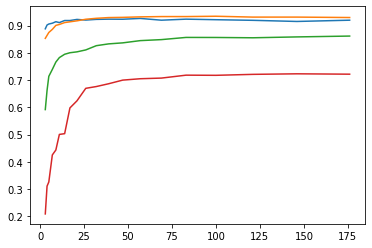

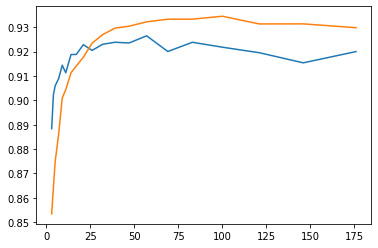

The best epoch of elmo is:  57
The best epoch of use is:  100
The best epoch of nnlm is:  176
The best epoch of gnew is:  146


In [15]:
early_stop = TCM.early_stop_searching()



In [16]:
for em in TCM.best_early_stop.keys():
    print(128* "=")
    print("The optimal stop epochs for model ", em,  " is ", TCM.best_early_stop[em])
print(128 * "=")

The optimal stop epochs for model  elmo  is  57
The optimal stop epochs for model  use  is  100
The optimal stop epochs for model  nnlm  is  176
The optimal stop epochs for model  gnew  is  146


## Test Set Evaluation

In [17]:
f1_test = TCM.evaluation_test_set()




Train on 8136 samples
Epoch 1/57
8136/8136 [==============================] - 1s 69us/sample - loss: 1.2817 - mean_absolute_error: 0.1932 - categorical_accuracy: 0.6860
Epoch 2/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.6743 - mean_absolute_error: 0.1192 - categorical_accuracy: 0.8768
Epoch 3/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.5042 - mean_absolute_error: 0.0902 - categorical_accuracy: 0.8984
Epoch 4/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.4238 - mean_absolute_error: 0.0753 - categorical_accuracy: 0.9077
Epoch 5/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.3757 - mean_absolute_error: 0.0661 - categorical_accuracy: 0.9152
Epoch 6/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.3420 - mean_absolute_error: 0.0598 - categorical_accuracy: 0.9197
Epoch 7/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.3183 - mean_abs

8136/8136 [==============================] - 0s 17us/sample - loss: 0.1196 - mean_absolute_error: 0.0216 - categorical_accuracy: 0.9691
Epoch 57/57
8136/8136 [==============================] - 0s 17us/sample - loss: 0.1185 - mean_absolute_error: 0.0215 - categorical_accuracy: 0.9690
f1_macro:  0.9272421278091516
f1_micro:  0.9258849557522124
f1_weighted:  0.9258979956773755
Train on 8136 samples
Epoch 1/100
8136/8136 [==============================] - 1s 67us/sample - loss: 1.7384 - mean_absolute_error: 0.2346 - categorical_accuracy: 0.7206
Epoch 2/100
8136/8136 [==============================] - 0s 16us/sample - loss: 1.4101 - mean_absolute_error: 0.2124 - categorical_accuracy: 0.8440
Epoch 3/100
8136/8136 [==============================] - 0s 16us/sample - loss: 1.1578 - mean_absolute_error: 0.1887 - categorical_accuracy: 0.8643
Epoch 4/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.9703 - mean_absolute_error: 0.1664 - categorical_accuracy: 0.8752
Epoch 5/1

8136/8136 [==============================] - 0s 16us/sample - loss: 0.2091 - mean_absolute_error: 0.0338 - categorical_accuracy: 0.9397
Epoch 54/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.2076 - mean_absolute_error: 0.0336 - categorical_accuracy: 0.9400
Epoch 55/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.2062 - mean_absolute_error: 0.0333 - categorical_accuracy: 0.9399
Epoch 56/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.2047 - mean_absolute_error: 0.0330 - categorical_accuracy: 0.9408
Epoch 57/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.2034 - mean_absolute_error: 0.0328 - categorical_accuracy: 0.9409
Epoch 58/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.2021 - mean_absolute_error: 0.0325 - categorical_accuracy: 0.9409
Epoch 59/100
8136/8136 [==============================] - 0s 16us/sample - loss: 0.2009 - mean_absolute_error: 0.0323 -

8136/8136 [==============================] - 0s 15us/sample - loss: 1.3397 - mean_absolute_error: 0.2055 - categorical_accuracy: 0.7743
Epoch 8/176
8136/8136 [==============================] - 0s 15us/sample - loss: 1.2780 - mean_absolute_error: 0.1995 - categorical_accuracy: 0.7840
Epoch 9/176
8136/8136 [==============================] - 0s 15us/sample - loss: 1.2225 - mean_absolute_error: 0.1937 - categorical_accuracy: 0.7891
Epoch 10/176
8136/8136 [==============================] - 0s 15us/sample - loss: 1.1725 - mean_absolute_error: 0.1882 - categorical_accuracy: 0.7962
Epoch 11/176
8136/8136 [==============================] - 0s 15us/sample - loss: 1.1273 - mean_absolute_error: 0.1829 - categorical_accuracy: 0.8015
Epoch 12/176
8136/8136 [==============================] - 0s 15us/sample - loss: 1.0864 - mean_absolute_error: 0.1778 - categorical_accuracy: 0.8052
Epoch 13/176
8136/8136 [==============================] - 0s 15us/sample - loss: 1.0491 - mean_absolute_error: 0.1730 - c

8136/8136 [==============================] - 0s 15us/sample - loss: 0.5349 - mean_absolute_error: 0.0874 - categorical_accuracy: 0.8623
Epoch 63/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.5320 - mean_absolute_error: 0.0868 - categorical_accuracy: 0.8618
Epoch 64/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.5290 - mean_absolute_error: 0.0862 - categorical_accuracy: 0.8626
Epoch 65/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.5264 - mean_absolute_error: 0.0856 - categorical_accuracy: 0.8631
Epoch 66/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.5236 - mean_absolute_error: 0.0851 - categorical_accuracy: 0.8637
Epoch 67/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.5210 - mean_absolute_error: 0.0846 - categorical_accuracy: 0.8631
Epoch 68/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.5184 - mean_absolute_error: 0.0840 -

Epoch 117/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4471 - mean_absolute_error: 0.0688 - categorical_accuracy: 0.8765
Epoch 118/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4462 - mean_absolute_error: 0.0686 - categorical_accuracy: 0.8761
Epoch 119/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4455 - mean_absolute_error: 0.0685 - categorical_accuracy: 0.8762
Epoch 120/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4447 - mean_absolute_error: 0.0683 - categorical_accuracy: 0.8765
Epoch 121/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4439 - mean_absolute_error: 0.0681 - categorical_accuracy: 0.8765
Epoch 122/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4432 - mean_absolute_error: 0.0680 - categorical_accuracy: 0.8767
Epoch 123/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4424 - mean_abso

8136/8136 [==============================] - 0s 15us/sample - loss: 0.4177 - mean_absolute_error: 0.0622 - categorical_accuracy: 0.8799
Epoch 172/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4173 - mean_absolute_error: 0.0621 - categorical_accuracy: 0.8799
Epoch 173/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4170 - mean_absolute_error: 0.0620 - categorical_accuracy: 0.8802
Epoch 174/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4166 - mean_absolute_error: 0.0620 - categorical_accuracy: 0.8802
Epoch 175/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4163 - mean_absolute_error: 0.0619 - categorical_accuracy: 0.8802
Epoch 176/176
8136/8136 [==============================] - 0s 15us/sample - loss: 0.4160 - mean_absolute_error: 0.0618 - categorical_accuracy: 0.8800
f1_macro:  0.8730787779989031
f1_micro:  0.870575221238938
f1_weighted:  0.8714477389200295
Train on 8136 samples


8136/8136 [==============================] - 0s 15us/sample - loss: 0.9033 - mean_absolute_error: 0.1388 - categorical_accuracy: 0.7178
Epoch 50/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.9004 - mean_absolute_error: 0.1383 - categorical_accuracy: 0.7199
Epoch 51/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8978 - mean_absolute_error: 0.1377 - categorical_accuracy: 0.7195
Epoch 52/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8953 - mean_absolute_error: 0.1372 - categorical_accuracy: 0.7206
Epoch 53/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8929 - mean_absolute_error: 0.1368 - categorical_accuracy: 0.7207
Epoch 54/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8906 - mean_absolute_error: 0.1362 - categorical_accuracy: 0.7205
Epoch 55/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8885 - mean_absolute_error: 0.1357 -

8136/8136 [==============================] - 0s 15us/sample - loss: 0.8367 - mean_absolute_error: 0.1231 - categorical_accuracy: 0.7313
Epoch 105/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8364 - mean_absolute_error: 0.1229 - categorical_accuracy: 0.7332
Epoch 106/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8357 - mean_absolute_error: 0.1228 - categorical_accuracy: 0.7329
Epoch 107/146
8136/8136 [==============================] - 0s 14us/sample - loss: 0.8354 - mean_absolute_error: 0.1227 - categorical_accuracy: 0.7340
Epoch 108/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8350 - mean_absolute_error: 0.1226 - categorical_accuracy: 0.7338
Epoch 109/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8346 - mean_absolute_error: 0.1224 - categorical_accuracy: 0.7322
Epoch 110/146
8136/8136 [==============================] - 0s 15us/sample - loss: 0.8338 - mean_absolute_error: 0.

In [18]:
for em in f1_test.keys():
    print(128 * "=")
    print("The f1_score of ", em, " on test set with optimal hyperparameters: ")
    print("macro f1_score: ", f1_test[em][0],"; micro f1_score: ", f1_test[em][1] )

The f1_score of  elmo  on test set with optimal hyperparameters: 
macro f1_score:  0.9272421278091516 ; micro f1_score:  0.9272421278091516
The f1_score of  use  on test set with optimal hyperparameters: 
macro f1_score:  0.9480198010884257 ; micro f1_score:  0.9480198010884257
The f1_score of  nnlm  on test set with optimal hyperparameters: 
macro f1_score:  0.8730787779989031 ; micro f1_score:  0.8730787779989031
The f1_score of  gnew  on test set with optimal hyperparameters: 
macro f1_score:  0.7289316196572201 ; micro f1_score:  0.7289316196572201


The model `elmo` and `universal_string_embedding` have the performance very close

# Sentences Demonstration

### Eager mode should be activated !

In [10]:
print(tf.executing_eagerly())
assert tf.executing_eagerly(), "Activate eager execution before"

test_phrases = ["Where is the nearest Starbucks ?", "i need to repair my car",
                "I need a ride from home", "I want to order something to eat", "can you activate",
                "I want a table in center city", "Ok that's it!"]
res = TCM.prediction('use', test_phrases)
print("Universal Standard Embedding: ")
for i in range(len(res)):
    print("The predicted topic of \"{} \" is : {}".format(test_phrases[i], res[i]))
res = TCM.prediction('elmo', test_phrases)
print(128 * "=")
print()

print("ELMo")
for i in range(len(res)):
    print("The predicted topic of \"{} \" is : {}".format(test_phrases[i], res[i]))

True
Universal Standard Embedding: 
The predicted topic of "Where is the nearest Starbucks ? " is : coffee
The predicted topic of "i need to repair my car " is : auto
The predicted topic of "I need a ride from home " is : uber
The predicted topic of "I want to order something to eat " is : restaurant
The predicted topic of "can you activate " is : non-opening
The predicted topic of "I want a table in center city " is : non-opening
The predicted topic of "Ok that's it! " is : non-opening

ELMo
The predicted topic of "Where is the nearest Starbucks ? " is : coffee
The predicted topic of "i need to repair my car " is : auto
The predicted topic of "I need a ride from home " is : uber
The predicted topic of "I want to order something to eat " is : pizza
The predicted topic of "can you activate " is : non-opening
The predicted topic of "I want a table in center city " is : restaurant
The predicted topic of "Ok that's it! " is : non-opening


# Conversation Demonstration

In [11]:
class Demo_Conversation(object):
    def __init__(self, model_cl):
        self.model_cl = model_cl
        self.classes_arr = ['auto', 'coffee', 'movie', 'non-opening', 'pizza','restaurant','uber']
        self.opening_response = {"auto" : "\tIt seems you want to repair your vehicle", \
                            "coffee" : "\tIt seems you want to order some coffee", \
                            "movie" : "\tIt seems you want to book movie tickets", \
                            "pizza" : "\tIt seems you want to order some pizza",\
                            "restaurant": "\tIt seems you want to book a table",\
                            "uber": "\tIt seems you want to take ride"}

    def inConversationDetected(self, embed = "elmo"):
        
        print("Conversation Test")
        print("Still working on it, not completed")
        print("Input \'~\' to stop")
        print(128 * "=")
        print("\tHello, what can I do for you?")
        print(128 * "-")
        userInput = ""
        current_topic = "non-opening";
        pre_topic = "non-opening"
        userInput = input()
        prediction = self.model_cl.prediction(embed, [userInput])[0]
        current_topic = prediction
        
        while current_topic == "non-opening":
            print("\t Sorry I can't understand what you mean")
            print(128 * "-")
            prediction = self.model_cl.prediction(embed, [userInput])[0]
            current_topic = prediction
            userInput = input()
        
        pre_topic = current_topic
        print("\ttopic predicted: ", current_topic)
        print("\tentering the scenario ", current_topic)
        print(self.opening_response[current_topic])
        
        
        while (userInput != "~"):  
            prediction = self.model_cl.prediction(embed, [userInput])[0]
            if prediction == "non-opening" or prediction == current_topic:
                print("\tno topic changing detected")
                userInput = input()
                continue
            
            print(128 * "-")
            current_topic = prediction
            print("\ttopic predicted: ", current_topic)
            print("\tentering the scenario ", current_topic)
            print(self.opening_response[current_topic])
            userInput = input()
        
        print("Goodbye, thank you for your attention")

In [12]:
DC = Demo_Conversation(TCM)

In [13]:
DC.inConversationDetected()

Conversation Test
Still working on it, not completed
Input '~' to stop
	Hello, what can I do for you?
--------------------------------------------------------------------------------------------------------------------------------
I want a ride
	topic predicted:  uber
	entering the scenario  uber
	It seems you want to take ride
	no topic changing detected


KeyboardInterrupt: 